In [1]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, to_tree, ClusterNode
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib as mpl
import datetime
import os
from itertools import accumulate
from math import floor
from pandas.tseries.offsets import MonthEnd
import plotting 
from matplotlib.colors import LogNorm, Normalize
from  matplotlib import colormaps as cmaps 
import matplotlib.patches as mpatches
from matplotlib import colors
from os import path
import json

In [2]:
_HOME_ = path.expanduser("~") + "/PHD"
import modify_dataset

In [3]:
phyto_abundances = pd.read_csv(_HOME_ + "/MSFD/Data/Modulo1/phyto_abund_modified.csv", index_col=0)
phyto_abundances.loc[:, "Date"] = pd.to_datetime(phyto_abundances["Date"])
with open(_HOME_ + "/ISPRA_20152017_Analysis/params.json") as file: 
    params = json.load(file)
best_path = params["best_path"]
best_path_sard = params["best_path_sard"]
ordered_regions = params["ordered_regions"]
seasons = params["seasons"]
sorted_season = params["sorted_season"]
sea_index = params["sea_index"]
ordered_id = params["ordered_id"]
sea_index_array = np.array(list(sea_index.values()))
del params
phyto_abund_simplified = modify_dataset.make_simplified_dataset(phyto_abundances, 0.7)
phyto_abund_simplified = modify_dataset.add_season_column(phyto_abund_simplified, seasons)
phyto_abund_simplified = modify_dataset.add_coast_dist_column(phyto_abund_simplified)
phyto_abund_simplified["Date"] = pd.to_datetime(phyto_abund_simplified["Date"]) + MonthEnd(0)
phyto_abund_simplified["Region"] = pd.Categorical(phyto_abund_simplified["Region"], categories = ordered_regions, ordered = True)
taxonomic_tree = pd.read_excel(_HOME_ + "/ISPRA_20152017_Analysis/Phyto_taxonomic_tree.xlsx")
taxonomic_tree.drop_duplicates(inplace=True)
phyto_abund_simplified = phyto_abund_simplified.merge(taxonomic_tree.loc[:,["ScientificName", "Genus", "Class"]], how = "left", left_on="Taxon", right_on="ScientificName")
phyto_abund_simplified["Class"] = phyto_abund_simplified["Class"].astype(str)
phyto_abund_simplified = modify_dataset.add_det_level_column(phyto_abund_simplified)
phyto_abund_simplified = phyto_abund_simplified.loc[:,
                                                    ["Region", "id", "Longitude", "Latitude", "Closest_coast", "Coast_dist", "Date", "Season_year", "Season", "Sample_depth", "Class", "Genus", "Det_level", "Taxon", "Num_cell_l", "file_name"]
                                                    ]
transects_info = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/transects_info.csv")
transects_info["Transect"] = transects_info["Transect"].str.upper()
phyto_abund_simplified = phyto_abund_simplified.merge(transects_info, how = "left", on = "id")

In [4]:
from_region_to_abreviation = {
    "Friuli-Venezia-Giulia" : "FVG",
    "Veneto" : "VEN", 
    "Emilia-Romagna" : "EMR",
    "Marche" : "MAR",
    "Abruzzo" : "ABR",
    "Molise" : "MOL",
    "Puglia" : "PUG",
    "Basilicata" : "BAS",
    "Calabria" : "CAL",
    "Campania" : "CAM", 
    "Lazio" : "LAZ",
    "Toscana" : "TOS",
    "Liguria" : "LIG",
     "Sicilia" : "SIC",
    "Sardegna" : "SAR"
}

In [5]:
phyto_abund_simplified["Region"] = phyto_abund_simplified["Region"].map(from_region_to_abreviation)

In [6]:
phyto_abund_simplified["Region"] = pd.Categorical(phyto_abund_simplified["Region"], categories = list(from_region_to_abreviation.values()), ordered = True)

In [7]:
from_region_to_zone = {
    "FVG" : "NordAdr", 
    "VEN" : "NordAdr",
    "EMR" : "NordAdr",
    "MAR" : "NordAdr",
    "ABR" : "SouthAdr",
    "MOL" : "SouthAdr",
    "PUG" : "SouthAdr",
    "BAS" : "Ion",
    "CAL" : "Ion",
    "CAM" : "SouthTyr", 
    "LAZ" : "SouthTyr",
    "TOS" : "Lig", 
    "LIG" : "Lig",
    "SIC" : "Ion",
    "SAR" : "WestMed"
}

In [8]:
phyto_abund_simplified["Basin"] = phyto_abund_simplified["Region"].map(from_region_to_zone)

In [9]:
phyto_abund_simplified.loc[phyto_abund_simplified["Transect"].isin(["PORTO_CESAREO", "PUNTA_RONDINELLA"]), "Basin"] = "Ion"
phyto_abund_simplified.loc[phyto_abund_simplified["Transect"].isin(["SAN_MARCO", "CAPO_GALLO", "ISOLE_EGADI"]), "Basin"] = "SouthTyr"
phyto_abund_simplified.loc[phyto_abund_simplified["Transect"].isin(["M1RM03", "M1VT04"]), "Basin"] = "Lig"
phyto_abund_simplified.loc[phyto_abund_simplified["Transect"].isin(["OLBIA", "ARBATAX", "CAGLIARI", "VILLASIMIUS"]), "Basin"] = "SouthTyr"

In [10]:
phyto_abund_simplified["Basin"] = pd.Categorical(phyto_abund_simplified["Basin"], categories = ["NordAdr", "SouthAdr", "Ion", "SouthTyr", "Lig", "WestMed"], ordered = True)

In [11]:
phyto_abund_simplified.loc[phyto_abund_simplified["Taxon"] == 'Pseudo-nitzschia spp. del nitzschia delicatissima complex', "Taxon"] = 'Nitzschia delicatissima complex'
phyto_abund_simplified.loc[phyto_abund_simplified["Taxon"] == 'Pseudo-nitzschia spp. del nitzschia seriata complex', "Taxon"] = 'Nitzschia seriata complex'

# First part

In [12]:
phyto_abund_simplified.query("Taxon != 'Other phytoplankton' and Det_level == 'Species'")[["Class", "Taxon"]].groupby("Class").nunique().sort_values("Taxon", ascending = False).to_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/phyto_classes.csv")

In [13]:
phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby("Taxon").count()["Num_cell_l"].quantile(np.arange(0, 1.05, 0.05))

0.00       1.00
0.05       1.00
0.10       1.00
0.15       1.00
0.20       2.00
0.25       3.00
0.30       4.00
0.35       5.00
0.40       7.00
0.45       8.25
0.50      12.00
0.55      16.00
0.60      22.00
0.65      30.00
0.70      44.00
0.75      63.00
0.80      90.00
0.85     131.25
0.90     216.50
0.95     416.50
1.00    1380.00
Name: Num_cell_l, dtype: float64

In [153]:
phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby("Taxon").count()[["Num_cell_l"]].query("Num_cell_l >416 ").sort_values(ascending=False, by = "Num_cell_l").to_csv(
    _HOME_ + "/ISPRA_20152017_Analysis/Description/Taxa_freq_95.csv")

In [154]:
freq_taxa = phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby("Taxon").count()[["Num_cell_l"]].query("Num_cell_l >= 416 ").sort_values(ascending=False, by = "Num_cell_l").index

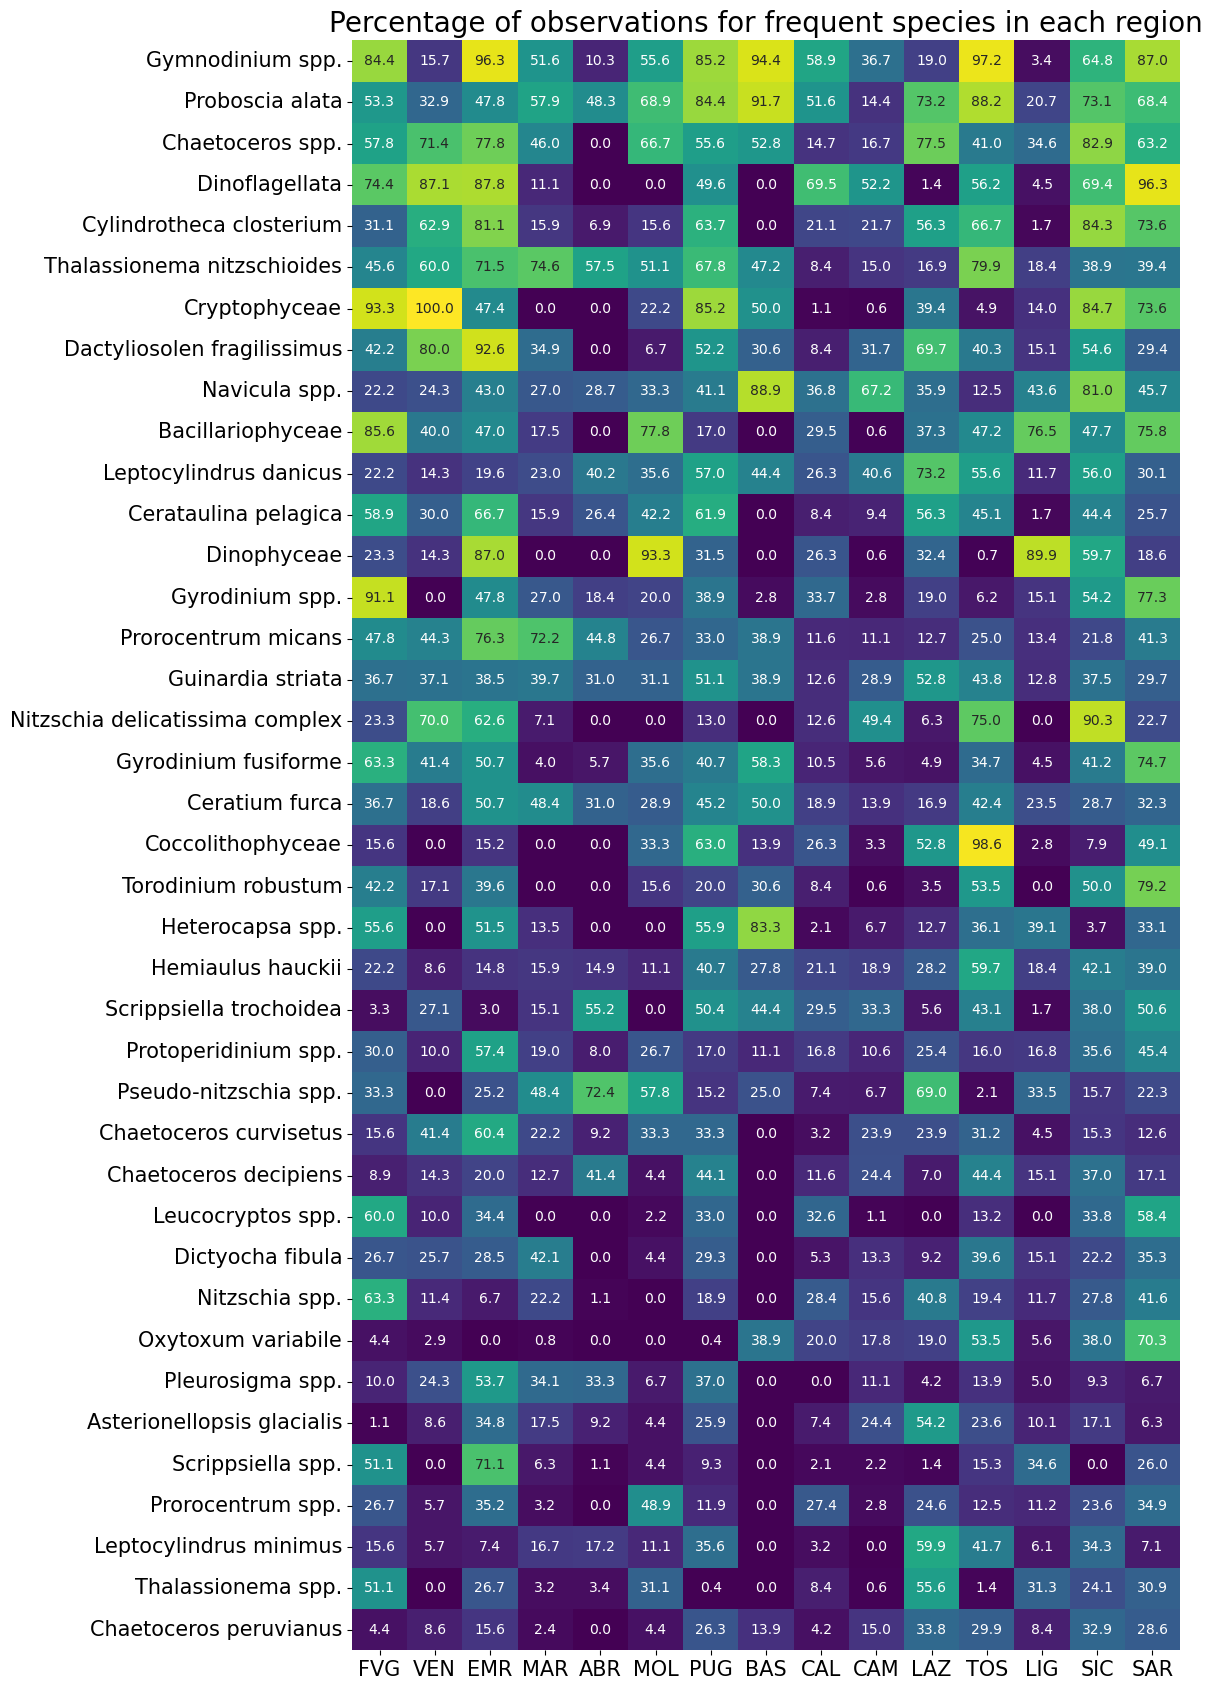

In [187]:
pres_abs = phyto_abund_simplified.query("Taxon in @freq_taxa").pivot_table(
    index= ["Region", "Date", "id"], 
    columns="Taxon",
    values="Num_cell_l",
    aggfunc="mean",
    fill_value=0
) > 0
pres_abs.reset_index(inplace=True)
n_region_samples = pres_abs.drop_duplicates(["Date", "id"]).groupby("Region", observed=True).count()["id"].to_numpy()
fig, ax = plt.subplots(figsize=(12, 17))

sns.heatmap(
data = pres_abs.groupby("Region", observed=True).sum(numeric_only=True).apply(lambda x: x / n_region_samples, axis=0).T.loc[freq_taxa, :] * 100, 
cmap = "viridis",
annot=True,
fmt=".1f",
ax = ax, 
cbar=False
)
ax.set_yticks(ax.get_yticks());
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, size = 15);
ax.set_xticks(ax.get_xticks());
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15);
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Percentage of observations for frequent species in each region", fontsize = 20)
plt.tight_layout()
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Description/Species_freq_95_heatmap.png", dpi = 300, bbox_inches = "tight")

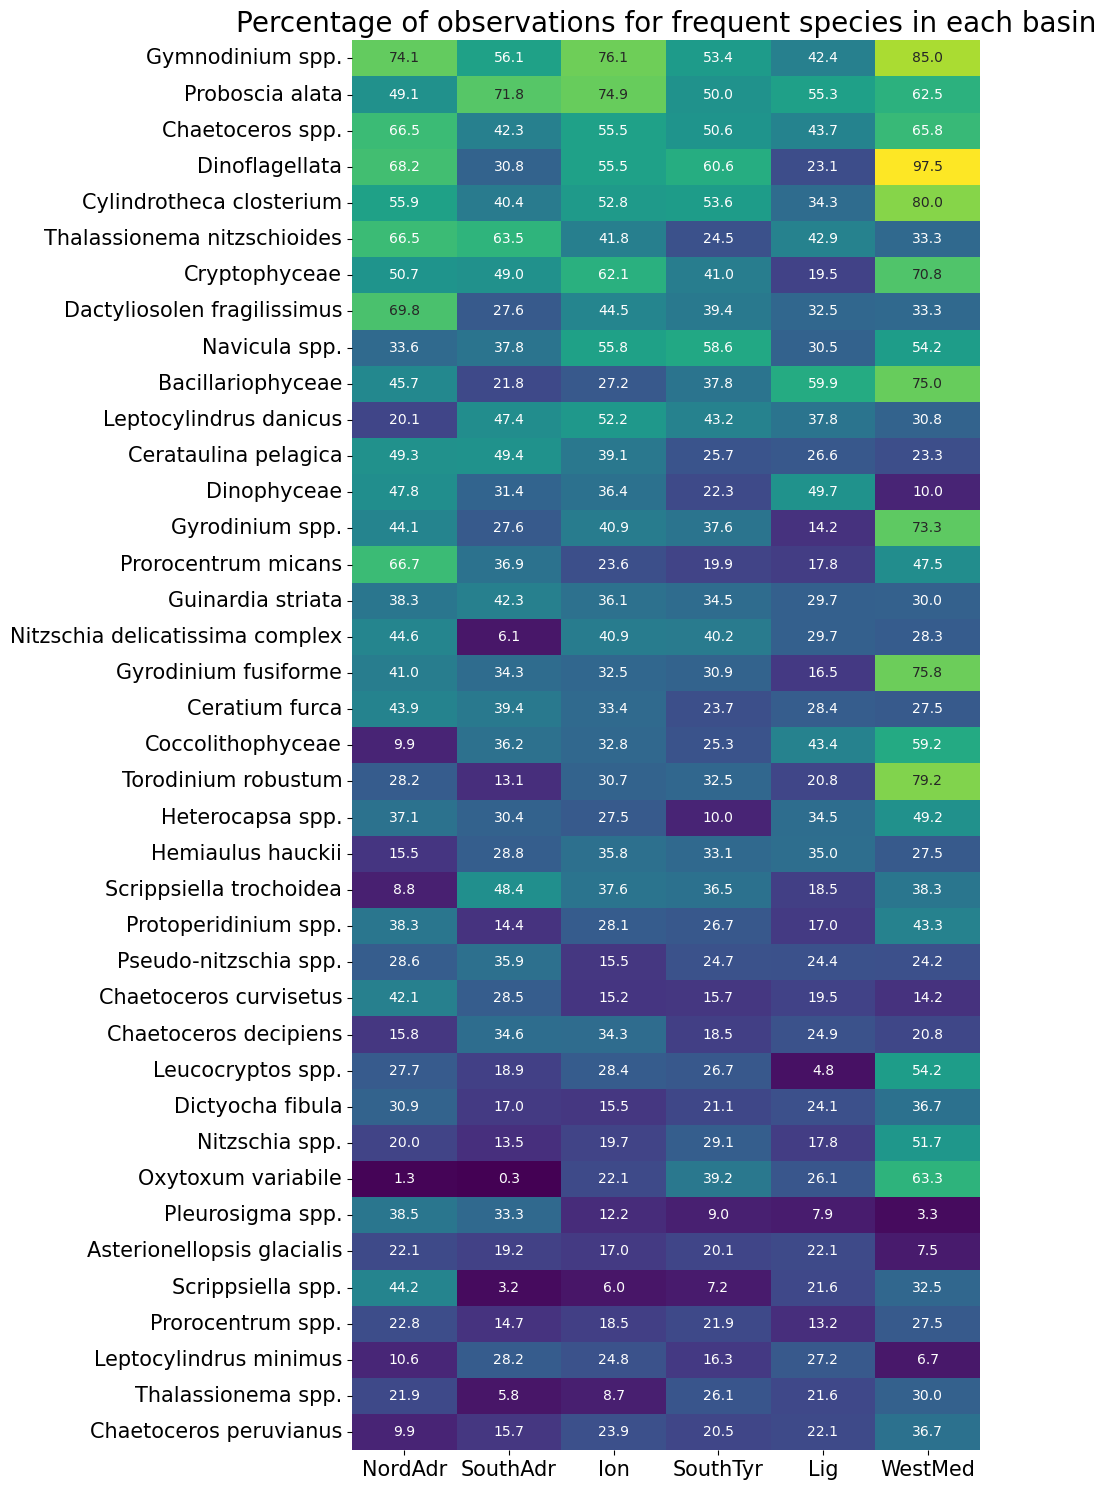

In [311]:
pres_abs = phyto_abund_simplified.query("Taxon in @freq_taxa").pivot_table(
    index= ["Basin", "Date", "id"], 
    columns="Taxon",
    values="Num_cell_l",
    aggfunc="mean",
    fill_value=0
) > 0
pres_abs.reset_index(inplace=True)
n_Basin_samples = pres_abs.drop_duplicates(["Date", "id"]).groupby("Basin", observed=True).count()["id"].to_numpy()


fig, ax = plt.subplots(figsize=(10, 15))

sns.heatmap(
data = pres_abs.groupby("Basin", observed=True).sum(numeric_only=True).apply(lambda x: x / n_Basin_samples, axis=0).T.loc[freq_taxa, :] * 100, 
cmap = "viridis",
annot=True,
fmt=".1f",
ax = ax, 
cbar=False
)
ax.set_yticks(ax.get_yticks());
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, size = 15);
ax.set_xticks(ax.get_xticks());
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15);
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Percentage of observations for frequent species in each basin", fontsize = 20)
plt.tight_layout()
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Description/Species_freq_95_heatmap_per_basin.png", dpi = 300, bbox_inches = "tight")

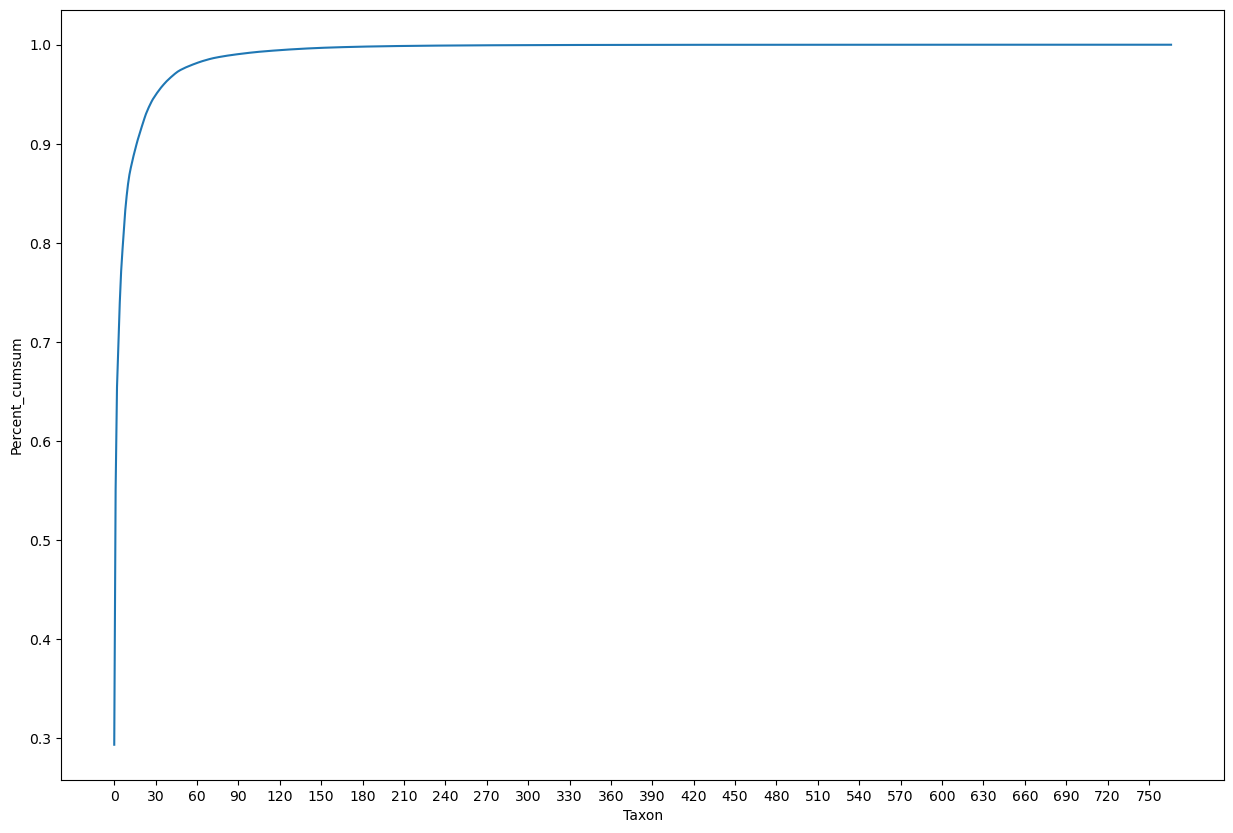

In [15]:
fig, ax = plt.subplots(figsize=(15, 10))

#.query("Taxon != 'Other phytoplankton'")
data = phyto_abund_simplified.groupby("Taxon").sum(numeric_only=True).sort_values("Num_cell_l", ascending = False)
data["Percent_cumsum"] = data["Num_cell_l"].cumsum() / data["Num_cell_l"].sum()
sns.lineplot(
    x = "Taxon",
    y = "Percent_cumsum",
    data = data,
    ax = ax
)
ax.set_xticks(np.arange(0, len(data), 30));
ax.set_xticklabels(np.arange(0, len(data), 30));

In [16]:
data["Percen_abund"] = data["Num_cell_l"] / data["Num_cell_l"].sum() * 100

In [22]:
abund_taxa = data.query("Percent_cumsum <= 0.95")["Percen_abund"].index

In [20]:
data.query("Percent_cumsum <= 0.95")["Percen_abund"].to_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/Species_abund_95.csv")

In [159]:
rel_taxa = set(freq_taxa).union(set(abund_taxa))

In [172]:
phyto_abund_simplified.groupby("Region", observed=True).nunique()[["Taxon"]]

,Taxon
Region,
FVG,221
VEN,146
EMR,290
MAR,227
ABR,107
MOL,113
PUG,378
BAS,75
CAL,209


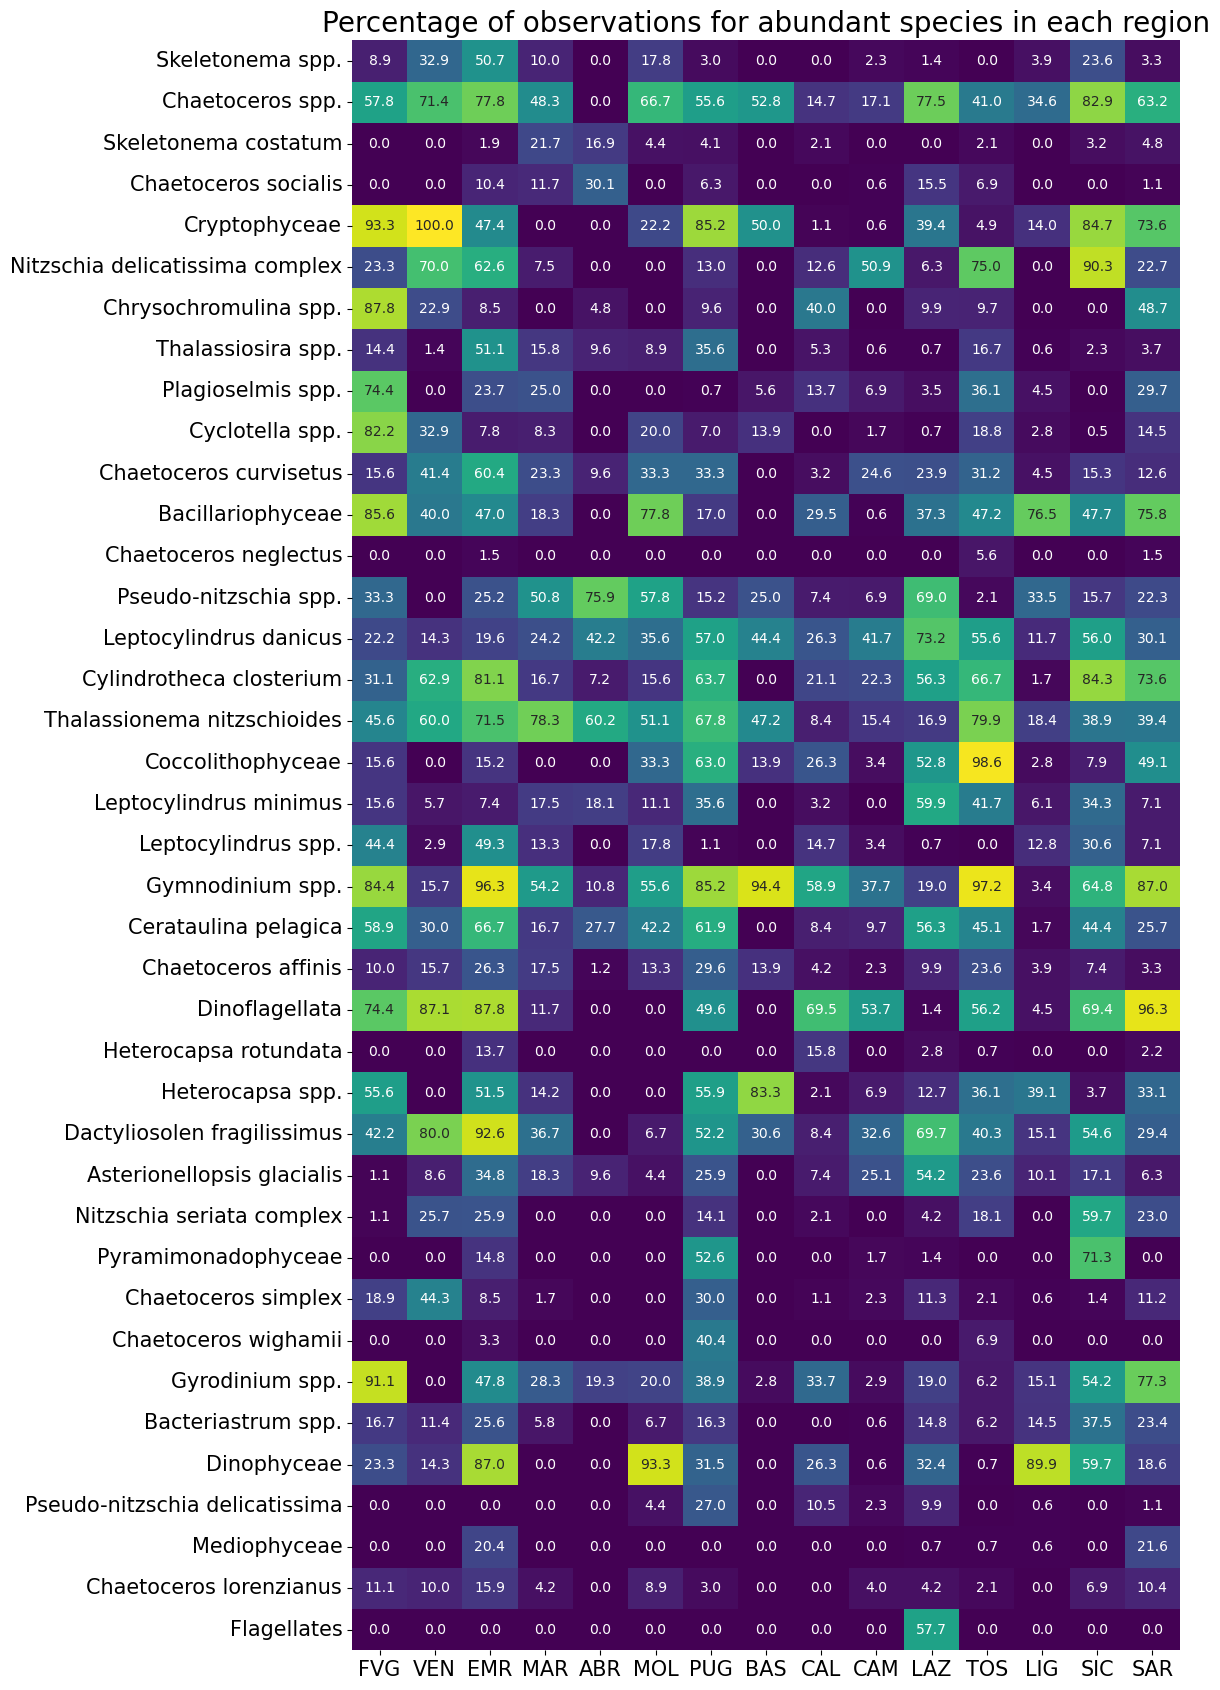

In [190]:
pres_abs = phyto_abund_simplified.query("Taxon in @abund_taxa").pivot_table(
    index= ["Region", "Date", "id"], 
    columns="Taxon",
    values="Num_cell_l",
    aggfunc="mean",
    fill_value=0
) > 0
pres_abs.reset_index(inplace=True)
n_region_samples = pres_abs.drop_duplicates(["Date", "id"]).groupby("Region", observed=True).count()["id"].to_numpy()

fig, ax = plt.subplots(figsize=(12, 17))

sns.heatmap(
data = pres_abs.groupby("Region", observed=True).sum(numeric_only=True).apply(lambda x: x / n_region_samples, axis=0).T.loc[abund_taxa, :] * 100, 
cmap = "viridis",
annot=True,
fmt=".1f",
ax = ax, 
cbar=False
)
ax.set_yticks(ax.get_yticks());
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, size = 15);
ax.set_xticks(ax.get_xticks());
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15);
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Percentage of observations for abundant species in each region", fontsize = 20)
plt.tight_layout()
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Description/Species_abund_95_heatmap.png", dpi = 300, bbox_inches = "tight")

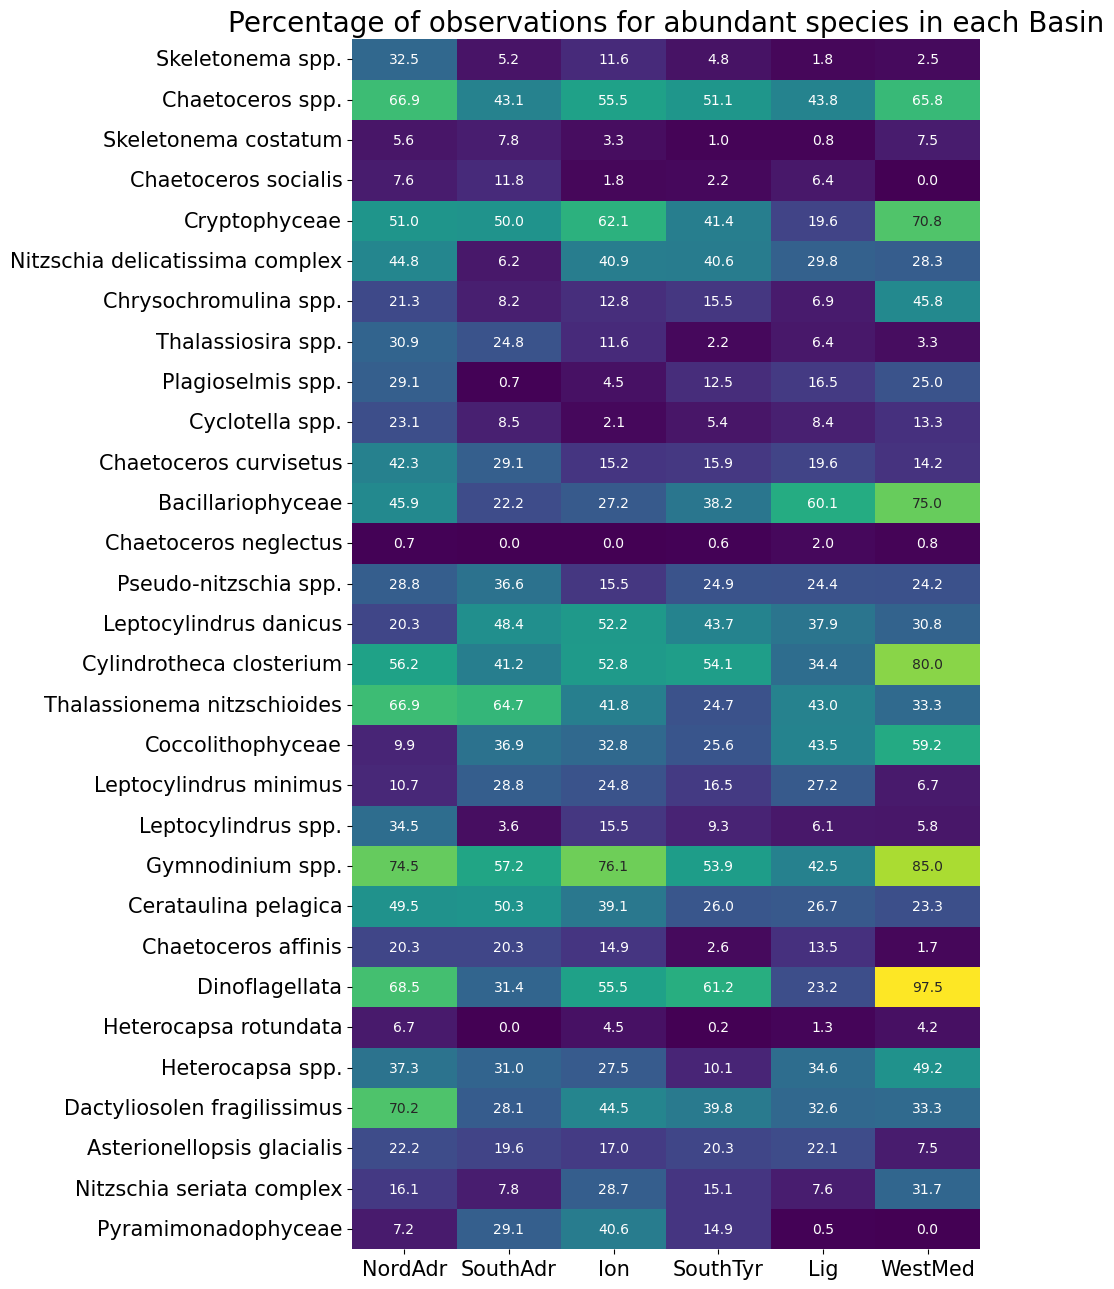

In [35]:
pres_abs = phyto_abund_simplified.query("Taxon in @abund_taxa").pivot_table(
    index= ["Basin", "Date", "id"], 
    columns="Taxon",
    values="Num_cell_l",
    aggfunc="mean",
    fill_value=0
) > 0
pres_abs.reset_index(inplace=True)
n_Basin_samples = pres_abs.drop_duplicates(["Date", "id"]).groupby("Basin", observed=True).count()["id"].to_numpy()

fig, ax = plt.subplots(figsize=(10, 13))

sns.heatmap(
data = pres_abs.groupby("Basin", observed=True).sum(numeric_only=True).apply(lambda x: x / n_Basin_samples, axis=0).T.loc[abund_taxa[1:], :] * 100, 
cmap = "viridis",
annot=True,
fmt=".1f",
ax = ax, 
cbar=False
)
ax.set_yticks(ax.get_yticks());
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, size = 15);
ax.set_xticks(ax.get_xticks());
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15);
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Percentage of observations for abundant species in each Basin", fontsize = 20)
plt.tight_layout()
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Description/Species_abund_95_heatmap_per_basin.png", dpi = 300, bbox_inches = "tight")

In [315]:
phyto_abund_simplified.loc[:, ["id", "Basin"]].drop_duplicates().to_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/Station_basin.csv", index=False)

In [317]:
indval = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/indval_per_basin.csv", )

In [321]:
import re
indval.iloc[:, 0] = indval.iloc[:, 0].apply(lambda x: re.sub(r'\.(?!$)', ' ', x))

In [324]:
np.sort(abund_taxa.intersection(set(indval.iloc[:, 0])))

array(['Bacillariophyceae', 'Cerataulina pelagica',
       'Chaetoceros curvisetus', 'Chaetoceros spp.', 'Coccolithophyceae',
       'Cylindrotheca closterium', 'Dactyliosolen fragilissimus',
       'Gymnodinium spp.', 'Gyrodinium spp.', 'Leptocylindrus spp.',
       'Skeletonema spp.', 'Thalassionema nitzschioides',
       'Thalassiosira spp.'], dtype=object)

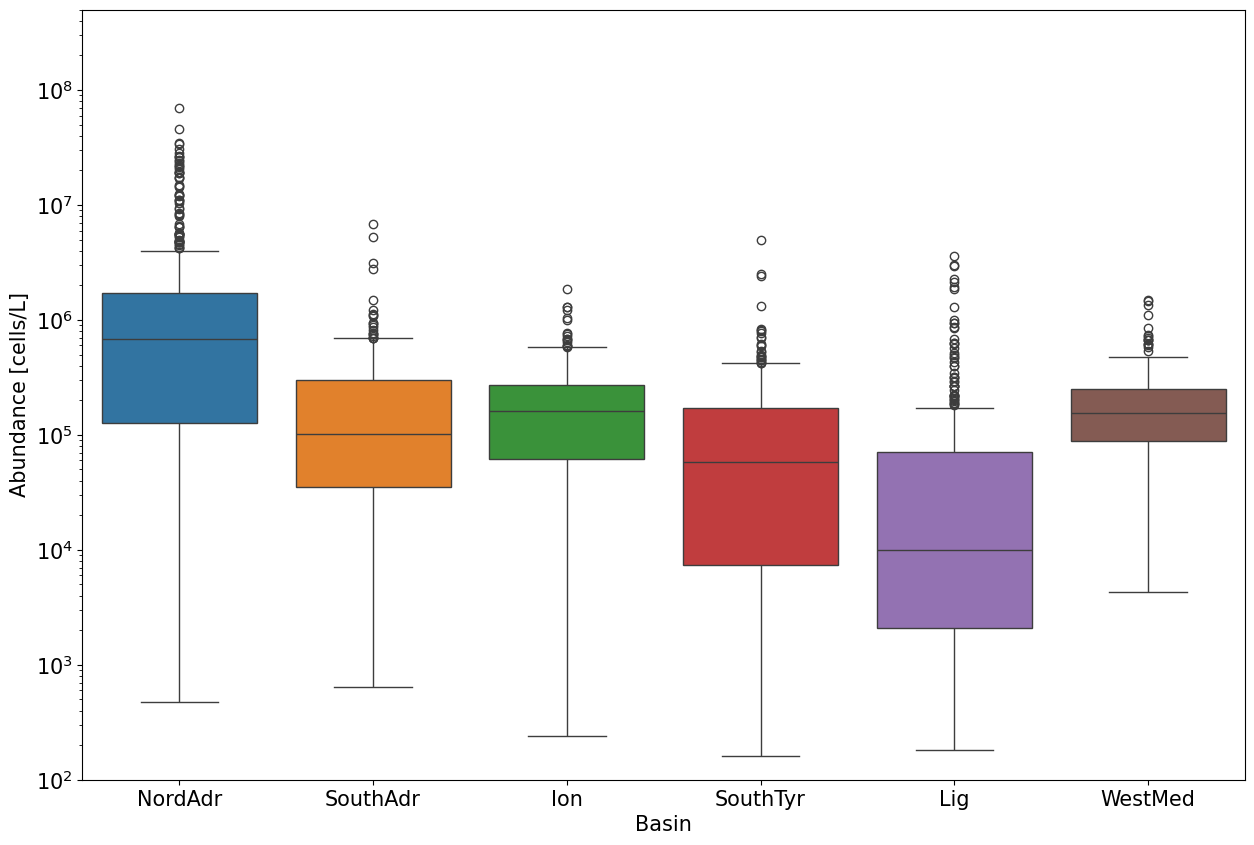

In [31]:
fig, ax = plt.subplots(figsize=(15, 10))

abund = phyto_abund_simplified.groupby(["Date", "id"]).agg(
    {"Num_cell_l" : "sum", 
     "Basin" : "first",
     }
)

sns.boxplot(
    x = "Basin",
    y = "Num_cell_l",
    data = abund,
    hue = "Basin",
    ax = ax
)
ax.set_yscale("log")
ax.set_ylabel("Abundance [cells/L]", size = 15)
ax.set_xlabel("Basin", size = 15)
ax.set_xticks(ax.get_xticks());
ax.set_xticklabels(ax.get_xticklabels(), size = 15);
ax.set_yticks(ax.get_yticks());
ax.set_yticklabels(ax.get_yticklabels(), size = 15);
ax.set_ylim(1e2, 5 * 1e8)
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Description/Abundance_per_basin.png", dpi = 300, bbox_inches = "tight")

In [55]:
"Heterocapsa niei" in phyto_abund_simplified["Taxon"].to_list()

True

In [63]:
phyto_abund_simplified.loc[phyto_abund_simplified["Taxon"].str.contains("hydroideus"), "Taxon"].unique()

array(['Ophiaster hydroideus'], dtype=object)

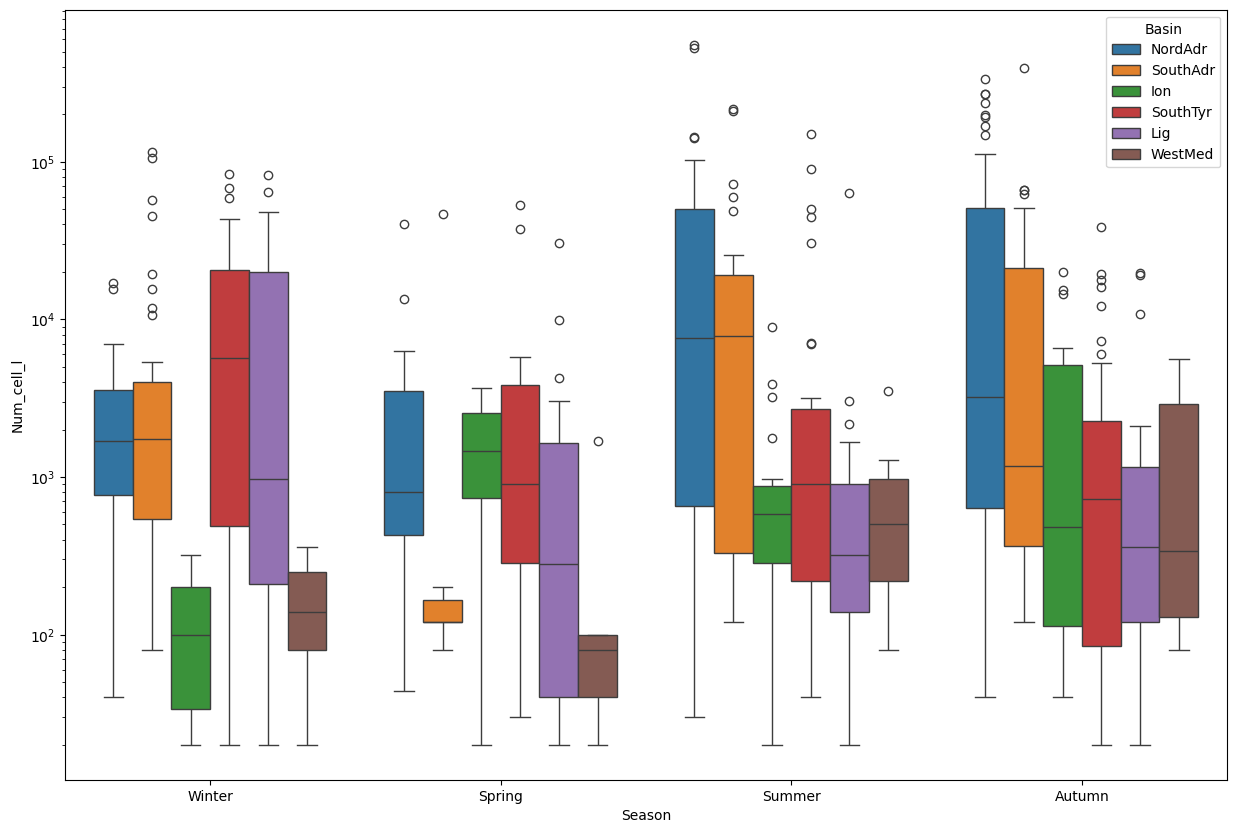

In [71]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.boxplot(
    data = phyto_abund_simplified.query("Taxon == 'Pseudo-nitzschia spp.'"), 
    x = "Season",
    y = "Num_cell_l", 
    hue = "Basin"
)
ax.set_yscale("log")

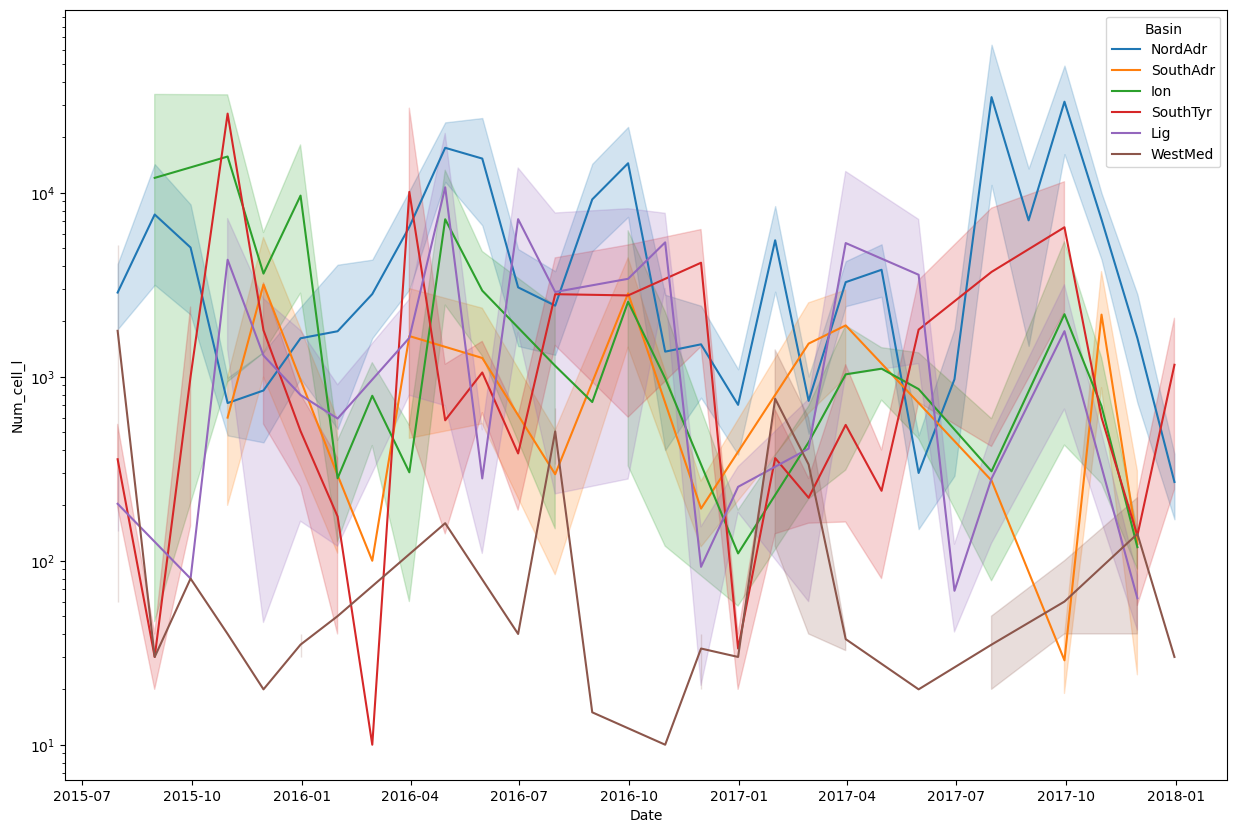

In [53]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.lineplot(
    data = phyto_abund_simplified.query("Taxon == 'Dactyliosolen fragilissimus'"), 
    x = "Date",
    y = "Num_cell_l", 
    hue = "Basin"
)
ax.set_yscale("log")

# Second Part

In [17]:
phyto_abund_simplified.query("Det_level == 'Species'").groupby("Taxon").count().sort_values("Region")["Region"].quantile(0.95)

331.55000000000007

In [22]:
phyto_abund_simplified.query("Det_level == 'Species'").groupby("Taxon").count()[["Region"]].sort_values("Region", ascending = False).query("Region > 332").to_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/Species_freq_top.csv")

In [27]:
phyto_abund_simplified.drop_duplicates(["Date", "id", "Genus"]).groupby("Genus").count()[["Region"]].quantile(0.95)

Region    1052.8
Name: 0.95, dtype: float64

In [28]:
phyto_abund_simplified.drop_duplicates(["Date", "id", "Genus"]).groupby("Genus").count()[["Region"]].sort_values("Region", ascending = False).query("Region > 1052").to_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/Genera_freq_top.csv")

In [29]:
phyto_abund_simplified["Det_level"].unique()

array(['Species', 'Genus', 'Higher cat.', 'Unknown'], dtype=object)

In [31]:
phyto_abund_simplified.drop_duplicates(["Date", "id", "Class"]).groupby("Class").count()[["Region"]].quantile(0.95)

Region    1945.6
Name: 0.95, dtype: float64

In [34]:
phyto_abund_simplified.drop_duplicates(["Date", "id", "Class"]).groupby("Class").count()[["Region"]].sort_values("Region", ascending = False).iloc[:12].to_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/Classes_freq_top.csv")

In [19]:
abund_taxa = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/Species_abund_95.csv").query("Taxon != 'Other phytoplankton'")["Taxon"].to_list()

In [23]:
abund_per_basin = phyto_abund_simplified.groupby(
    "Basin", observed=True
).sum(numeric_only=True)[["Num_cell_l"]]

In [43]:
abund_distribution = phyto_abund_simplified.query("Taxon in @abund_taxa").groupby(["Taxon", "Basin"], observed=True).sum(numeric_only=True)[["Num_cell_l"]].pivot_table(index="Taxon", columns="Basin", values="Num_cell_l", fill_value=0).loc[abund_taxa,:] / abund_per_basin.T.to_numpy() * 100

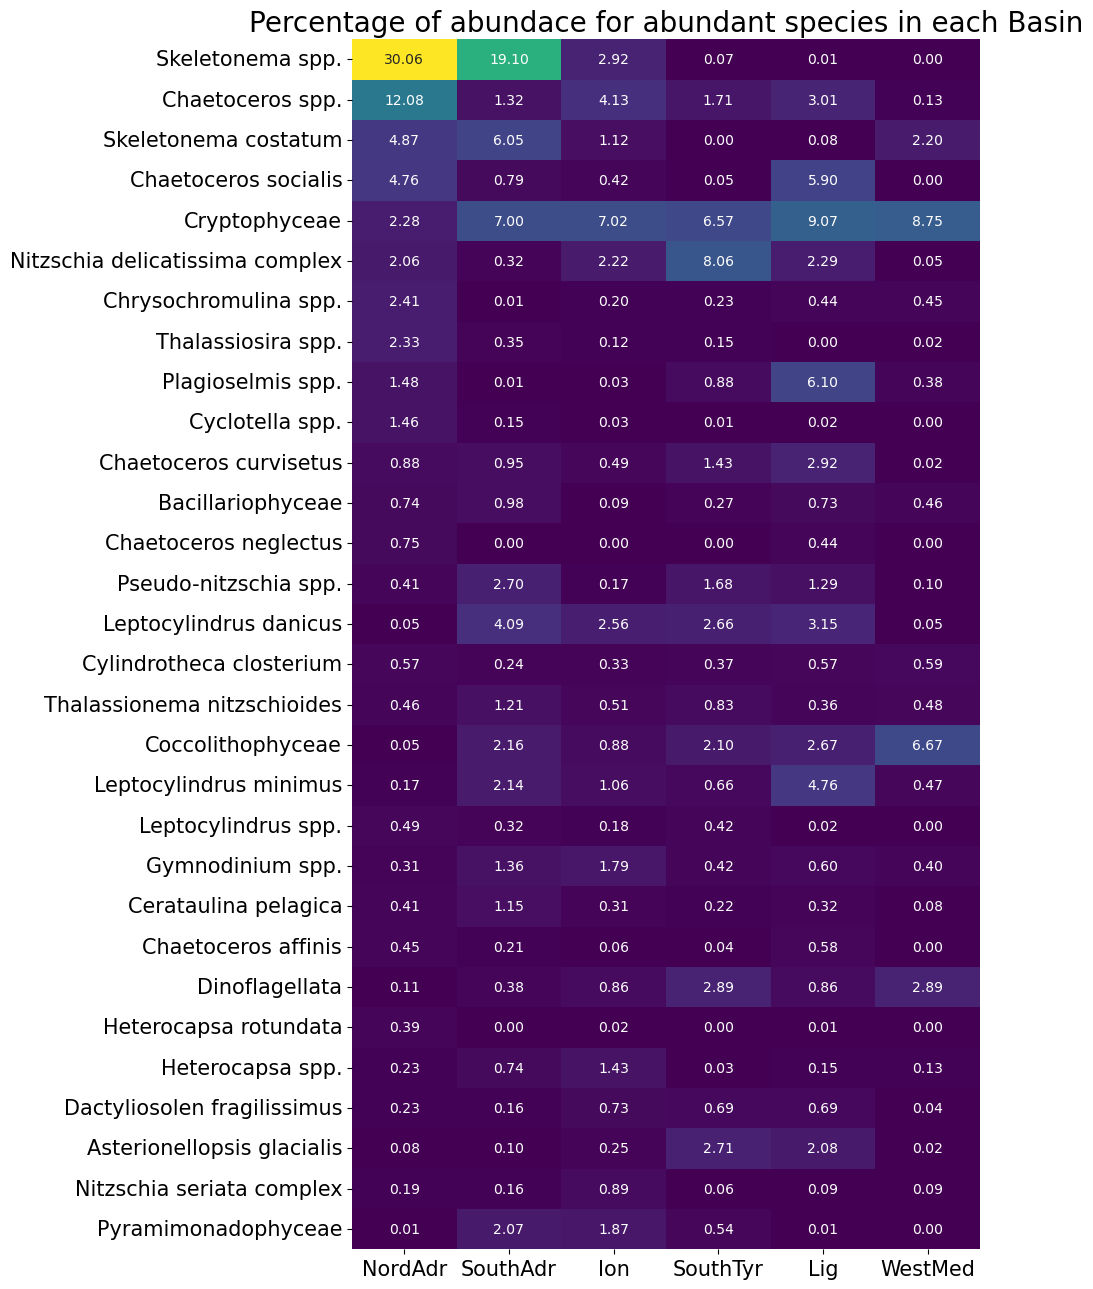

In [46]:
fig, ax = plt.subplots(figsize=(10, 13))

sns.heatmap(
data = abund_distribution, 
cmap = "viridis",
annot=True,
fmt=".2f",
ax = ax, 
cbar=False
)
ax.set_yticks(ax.get_yticks());
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, size = 15);
ax.set_xticks(ax.get_xticks());
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15);
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Percentage of abundace for abundant species in each Basin", fontsize = 20)
plt.tight_layout()
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Description/Species_abund_distribution_heatmap_per_basin.png", dpi = 300, bbox_inches = "tight")